In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [2]:
df1 = pd.read_csv('data_01.csv')
df2 = pd.read_csv('data_02.csv')
df3 = pd.read_csv('data_03.csv')
df4 = pd.read_csv('data_04.csv')
df5 = pd.read_csv('data_05.csv')
df6 = pd.read_csv('data_06.csv')
dfs = [df1, df2, df3, df4, df5, df6]

In [3]:
lens = [dfs[i].shape[0] for i in range(len(dfs))]
indices = []
for i, count in enumerate(lens):
  for _ in range(count):
    indices.append(i)

In [4]:
df = pd.concat(dfs)
x = df['x']
y = df['y']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


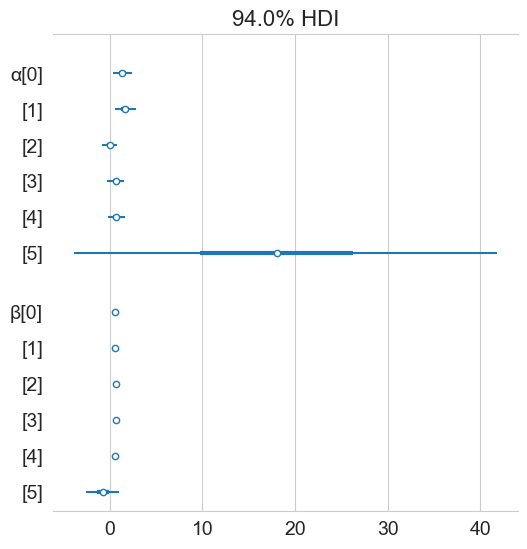

In [11]:
M = 6

x_centered = x - x.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[indices] + β[indices] * x_centered,
                         sigma=ε, nu=ν, observed=y)

    α = pm.Deterministic('α', α_tmp - β * x.mean())

    trace_up = pm.sample(2000, idata_kwargs={"log_likelihood": True})
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


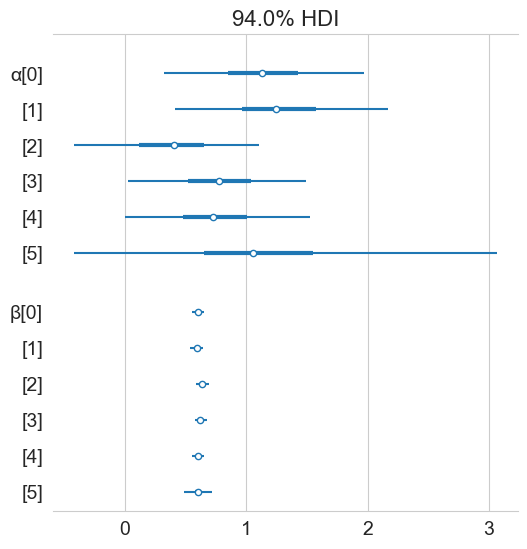

In [12]:
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[indices] + β[indices] * x_centered,
                         sigma=ε, nu=ν, observed=y)

    α = pm.Deterministic('α', α_tmp - β * x.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x.mean())

    trace_hm = pm.sample(3000,tune = 1000, idata_kwargs={"log_likelihood": True})

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

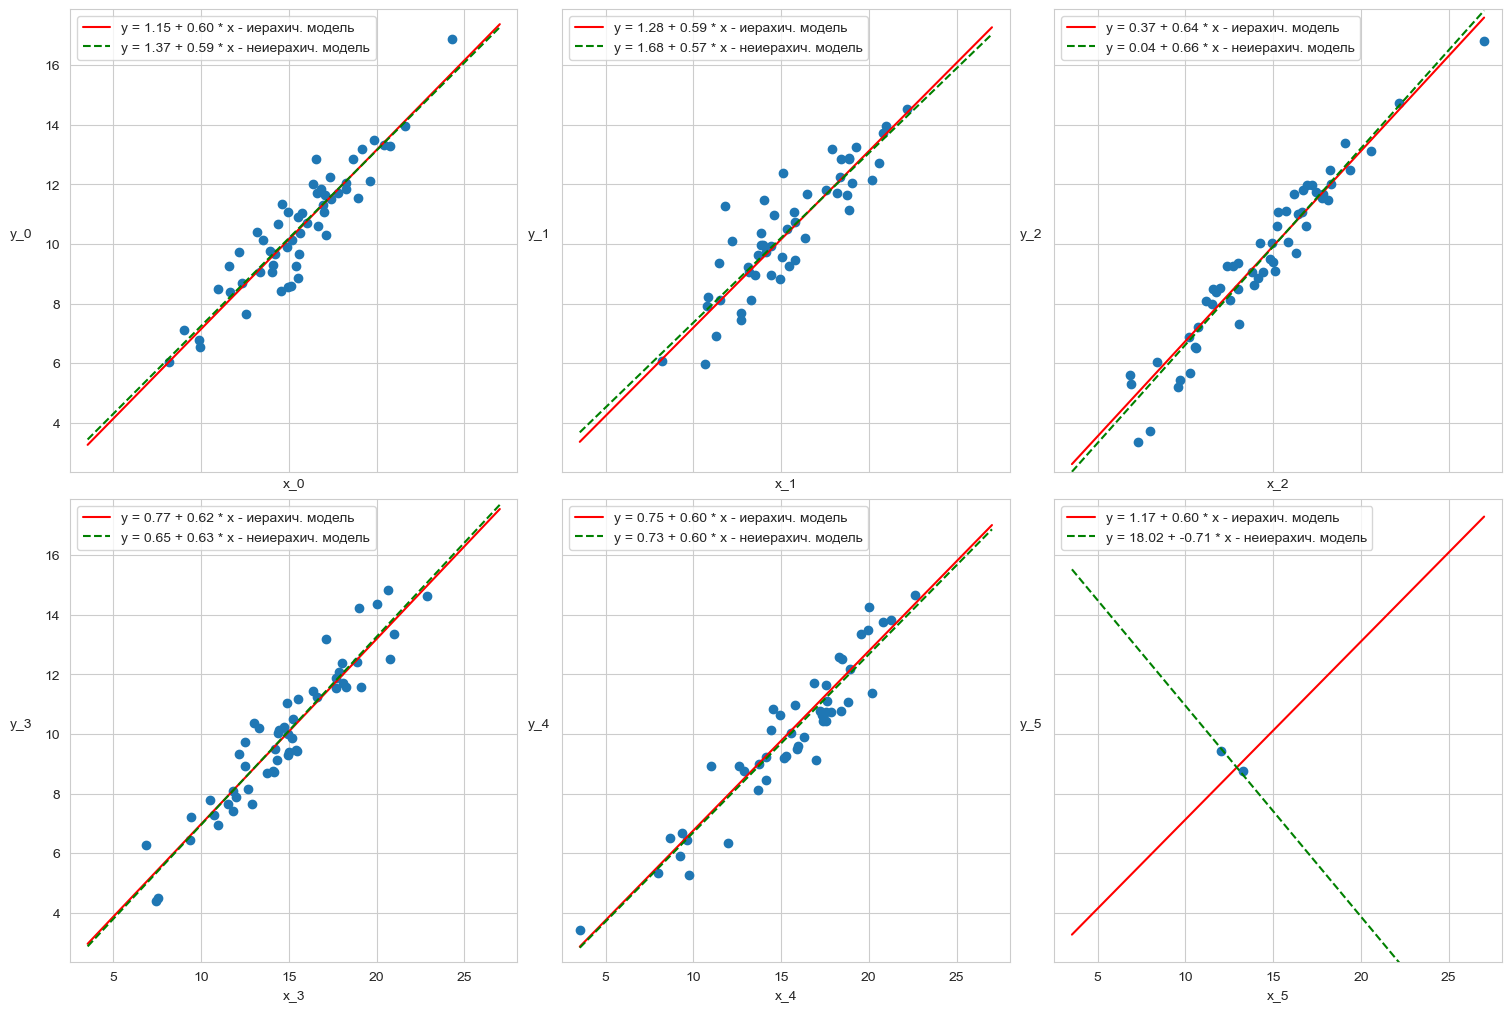

In [13]:
_, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})
trace_upp = trace_up.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, indices.count(0)
x_range = np.linspace(x.min(), x.max(), 10)

for i in range(M):
    ax[i].scatter(x[j:k], y[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')

    alpha_o = trace_upp['α'].sel({'α_dim_0':i}).mean().item()
    beta_o = trace_upp['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_o + beta_o * x_range, 'g--',
               label=f'y = {alpha_o:.2f} + {beta_o:.2f} * x'+' - неиерахич. модель')

    ax[i].legend()
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    j += indices.count(i)
    k += indices.count(i + 1)

In [14]:
display(az.summary(trace_up,var_names=['α', 'β']))
display(az.summary(trace_hm,var_names=['α', 'β']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.369,0.550,0.320,2.389,0.007,0.005,6461.0,4176.0,1.0
α[1],1.679,0.597,0.590,2.810,0.007,0.005,7802.0,4565.0,1.0
α[2],0.041,0.435,-0.781,0.833,0.005,0.006,8428.0,4558.0,1.0
α[3],0.653,0.497,-0.279,1.579,0.005,0.005,8581.0,4363.0,1.0
α[4],0.726,0.492,-0.154,1.685,0.006,0.005,7083.0,4147.0,1.0
α[5],18.017,12.277,-3.870,41.737,0.178,0.134,4787.0,4269.0,1.0
β[0],0.589,0.035,0.524,0.653,0.000,0.000,6881.0,4205.0,1.0
β[1],0.568,0.038,0.499,0.639,0.000,0.000,7957.0,4483.0,1.0
β[2],0.658,0.029,0.603,0.712,0.000,0.000,7546.0,4211.0,1.0
β[3],0.630,0.033,0.569,0.692,0.000,0.000,8146.0,4393.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.147,0.437,0.320,1.968,0.007,0.005,4217.0,5504.0,1.0
α[1],1.279,0.469,0.415,2.165,0.008,0.006,3586.0,3297.0,1.0
α[2],0.371,0.405,-0.423,1.102,0.009,0.007,1870.0,1651.0,1.0
α[3],0.775,0.391,0.024,1.495,0.006,0.005,4379.0,4932.0,1.0
α[4],0.746,0.402,-0.001,1.528,0.006,0.004,4341.0,5105.0,1.0
α[5],1.167,0.970,-0.418,3.064,0.019,0.017,3802.0,2425.0,1.0
β[0],0.600,0.027,0.552,0.653,0.000,0.000,3934.0,5503.0,1.0
β[1],0.592,0.030,0.534,0.645,0.001,0.000,3050.0,4399.0,1.0
β[2],0.637,0.027,0.588,0.688,0.001,0.000,1822.0,2242.0,1.0
β[3],0.621,0.025,0.575,0.672,0.000,0.000,4503.0,4967.0,1.0


In [15]:
traces = [trace_up, trace_hm]

model_dict = dict(zip(["model_0", "model_1"], traces))
comp = az.compare(model_dict)
comp

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dty

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_1,0,-329.193647,9.171123,0.00000,1.0,11.318828,0.000000,False,log
model_0,1,-331.777907,12.904867,2.58426,0.0,10.987206,2.035016,True,log


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


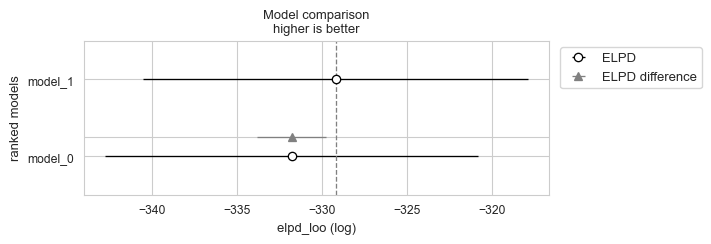

In [16]:
az.plot_compare(comp);